##Exercise Overview
In this exercise we will play with Spark [Datasets & Dataframes](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes), some [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), and build a couple of binary classification models using [Spark ML](https://spark.apache.org/docs/latest/ml-guide.html) (with some [MLlib](https://spark.apache.org/mllib/) too). 
<br><br>
The set up and approach will not be too different from the standard type of approach you might do in [Sklearn](http://scikit-learn.org/stable/index.html). Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.  
<br>
Feel free to adapt this exercise to play with other datasets readily available in the Databricks enviornment (they are listed in a cell below). 
#####Getting Started
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with: 
- Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)
- Python Version 3

#####Links & References

Some useful links and references of sources used in creating this exercise:

**Note**: Right click and open as new tab!
<br>
1. [Latest Spark Docs](https://spark.apache.org/docs/latest/index.html)
1. [Databricks Homepage](https://databricks.com/)
1. [Databricks Community Edition FAQ](https://databricks.com/product/faq/community-edition)
1. [Databricks Self Paced Training](https://databricks.com/training-overview/training-self-paced)
1. [Databricks Notebook Guide](https://docs.databricks.com/user-guide/notebooks/index.html)
1. [Databricks Binary Classification Tutorial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification)

####Get Data

Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).

In [3]:
# display datasets already in databricks
display(dbutils.fs.ls("/databricks-datasets")) 

path,name,size
dbfs:/databricks-datasets/,databricks-datasets/,0
dbfs:/databricks-datasets/COVID/,COVID/,0
dbfs:/databricks-datasets/README.md,README.md,976
dbfs:/databricks-datasets/Rdatasets/,Rdatasets/,0
dbfs:/databricks-datasets/SPARK_README.md,SPARK_README.md,3359
dbfs:/databricks-datasets/adult/,adult/,0
dbfs:/databricks-datasets/airlines/,airlines/,0
dbfs:/databricks-datasets/amazon/,amazon/,0
dbfs:/databricks-datasets/asa/,asa/,0
dbfs:/databricks-datasets/atlas_higgs/,atlas_higgs/,0


Lets take a look at the '**adult**' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. [Here](https://archive.ics.uci.edu/ml/datasets/adult) is the same data in the UCI repository.

_As an aside: [here](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census) this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here)._

In [5]:
%fs ls databricks-datasets/adult/adult.data

path,name,size
dbfs:/databricks-datasets/adult/adult.data,adult.data,3974305


**Note**: Above  %fs is just some file system cell magic that is specific to databricks. More info [here](https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages).

####Spark SQL
Below we will use Spark SQL to load in the data and then register it as a Dataframe as well. So, the end result will be a Spark SQL table called _adult_ and a Spark Dataframe called _df_adult_. 
<br><br>
This is an example of the flexibility in Spark in that you could do lots of ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.
<br><br>
When you get more advanced then you might want to look into the pro's and con's of each, and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

In [8]:
%sql
-- drop the table if it already exists
DROP TABLE IF EXISTS adult

In [9]:
%sql
-- create a new table in Spark SQL from the datasets already loaded in the underlying filesystem.
-- In the real world you might point at a file on HDFS or a hive table etc. 
CREATE TABLE adult (
  age DOUBLE,
  workclass STRING,
  fnlwgt DOUBLE,
  education STRING,
  education_num DOUBLE,
  marital_status STRING,
  occupation STRING,
  relationship STRING,
  race STRING,
  sex STRING,
  capital_gain DOUBLE,
  capital_loss DOUBLE,
  hours_per_week DOUBLE,
  native_country STRING,
  income STRING)
USING com.databricks.spark.csv
OPTIONS (path "/databricks-datasets/adult/adult.data", header "true")

In [10]:
# look at the data
#spark.sql("SELECT * FROM adult LIMIT 5").show() 
# this will look prettier in Databricks if you use display() instead
display(spark.sql("SELECT * FROM adult LIMIT 5"))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K


If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.

In [12]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)
display(result)

occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
Prof-specialty,4140,0.53,0.02,0.13,0.02,0.3
Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
Exec-managerial,4066,0.61,0.02,0.15,0.02,0.2
Adm-clerical,3769,0.28,0.04,0.22,0.04,0.42
Sales,3650,0.47,0.03,0.12,0.03,0.36
Other-service,3295,0.24,0.05,0.15,0.06,0.5
Machine-op-inspct,2002,0.51,0.03,0.14,0.04,0.29
?,1843,0.36,0.08,0.1,0.04,0.42
Transport-moving,1597,0.63,0.02,0.11,0.02,0.21
Handlers-cleaners,1370,0.36,0.01,0.09,0.03,0.51


You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.

In [14]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
spark.sql("SELECT * FROM result").show(5)

+----------------+----+------------+----------+------------+--------------+-------------+
 occupation| n|married_rate|widow_rate|divorce_rate|separated_rate|bachelor_rate|
+----------------+----+------------+----------+------------+--------------+-------------+
 Prof-specialty|4140| 0.53| 0.02| 0.13| 0.02| 0.3|
 Craft-repair|4099| 0.64| 0.01| 0.11| 0.03| 0.21|
 Exec-managerial|4066| 0.61| 0.02| 0.15| 0.02| 0.2|
 Adm-clerical|3769| 0.28| 0.04| 0.22| 0.04| 0.42|
 Sales|3650| 0.47| 0.03| 0.12| 0.03| 0.36|
+----------------+----+------------+----------+------------+--------------+-------------+
only showing top 5 rows

####<span style="color:darkblue">Question 1</span>

1. Write some spark sql to get the top 'bachelor_rate' by 'education' group?

In [16]:
### Question 1.1 Answer ###

results = spark.sql("""
select 
  education,
  ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
from adult
group by education
order by bachelor_rate desc
limit 1
""")

results.show()

+---------+-------------+
education|bachelor_rate|
+---------+-------------+
 12th| 0.54|
+---------+-------------+

####Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [18]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns # this will be used much later in the notebook, ignore for now

In [19]:
# look at df schema
df_adult.printSchema()

root
-- age: double (nullable = true)
-- workclass: string (nullable = true)
-- fnlwgt: double (nullable = true)
-- education: string (nullable = true)
-- education_num: double (nullable = true)
-- marital_status: string (nullable = true)
-- occupation: string (nullable = true)
-- relationship: string (nullable = true)
-- race: string (nullable = true)
-- sex: string (nullable = true)
-- capital_gain: double (nullable = true)
-- capital_loss: double (nullable = true)
-- hours_per_week: double (nullable = true)
-- native_country: string (nullable = true)
-- income: string (nullable = true)

In [20]:
# look at the df
display(df_adult)
#df_adult.show(5)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
49.0,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
52.0,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
31.0,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
42.0,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K
37.0,Private,280464.0,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,0.0,80.0,United-States,>50K


Below we will do a similar calculation to what we did above but using the DataFrames API

In [22]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
 occupation|divorced_rate|
+----------------+-------------+
 Adm-clerical| 0.22|
 Priv-house-serv| 0.19|
 Tech-support| 0.15|
 Other-service| 0.15|
 Exec-managerial| 0.15|
+----------------+-------------+
only showing top 5 rows

As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.<br><br>But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

####<span style="color:darkblue">Question 2</span>
1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [25]:
### Question 2.1 Answer ###

# wrangle the data a bit
df_result = df_adult.select(df_adult.education, when(df_adult.marital_status==' Never-married',1).otherwise(0).alias('is_bachelor')).groupBy('education').agg(round(mean('is_bachelor'),2).alias('bachelor_rate')).orderBy(desc('bachelor_rate'))

df_result.show(1)

+---------+-------------+
education|bachelor_rate|
+---------+-------------+
 12th| 0.54|
+---------+-------------+
only showing top 1 row

####Explore & Visualize Data
It's very easy to [collect()](https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd) your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.
<br><br>
Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.

In [27]:
import pandas as pd

# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

occupation plus_50k
0 Exec-managerial 0.484014
1 Prof-specialty 0.449034
2 Protective-serv 0.325116
3 Tech-support 0.304957
4 Sales 0.269315

In [28]:
print(df_pandas.describe())

plus_50k
count 15.000000
mean 0.197357
std 0.143993
min 0.006711
25% 0.107373
50% 0.134518
75% 0.287136
max 0.484014

In [29]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 occupation 15 non-null object 
 1 plus_50k 15 non-null float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes
None

Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity, we are going to use the plotting functionality built into pandas (you could make this as pretty as you want).

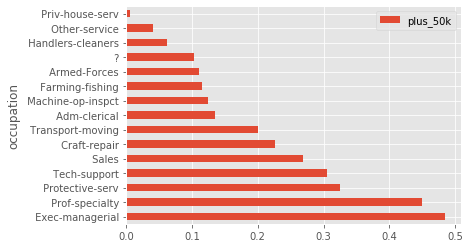

In [31]:
import matplotlib.pyplot as plt

# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.<br><br>So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [33]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+------------------+
summary| age| education_num|
+-------+------------------+------------------+
 count| 32560| 32560|
 mean|38.581633906633904| 10.08058968058968|
 stddev|13.640641827464002|2.5727089681052058|
 min| 17.0| 1.0|
 max| 90.0| 16.0|
+-------+------------------+------------------+

### ML Pipeline - Logistic Regression vs Random Forest

Below we will create two [Spark ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

**Note**: A lot of the code below is adapted from [this example](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html).

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [36]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [37]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [38]:
# Create a Pipeline
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
display(dataset)

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0.0,"List(0, 100, List(1, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 83311.0, 13.0, 13.0))",50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
0.0,"List(0, 100, List(0, 8, 25, 38, 44, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 38.0, 215646.0, 9.0, 40.0))",38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
0.0,"List(0, 100, List(0, 13, 23, 38, 43, 49, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 53.0, 234721.0, 7.0, 40.0))",53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
0.0,"List(0, 100, List(0, 10, 23, 29, 47, 49, 62, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28.0, 338409.0, 13.0, 40.0))",28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
0.0,"List(0, 100, List(0, 11, 23, 31, 47, 48, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37.0, 284582.0, 14.0, 40.0))",37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
0.0,"List(0, 100, List(0, 18, 28, 34, 44, 49, 64, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 49.0, 160187.0, 5.0, 16.0))",49.0,Private,160187.0,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
1.0,"List(0, 100, List(1, 8, 23, 31, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 52.0, 209642.0, 9.0, 45.0))",52.0,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
1.0,"List(0, 100, List(0, 11, 24, 29, 44, 48, 53, 94, 95, 96, 97, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 31.0, 45781.0, 14.0, 14084.0, 50.0))",31.0,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
1.0,"List(0, 100, List(0, 10, 23, 31, 43, 48, 52, 53, 94, 95, 96, 97, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 42.0, 159449.0, 13.0, 5178.0, 40.0))",42.0,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K
1.0,"List(0, 100, List(0, 9, 23, 31, 43, 49, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 37.0, 280464.0, 10.0, 80.0))",37.0,Private,280464.0,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,0.0,80.0,United-States,>50K


In [39]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22831
9729

In [40]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.2398931277648811

####Logistic Regression - Train

In [42]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positive rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.382027978317939

####GBM - Train

####<span style="color:darkblue">Question 3</span>
1. Train a GBTClassifier on the training data, call the trained model 'gbModel'

In [45]:
from pyspark.ml.classification import GBTClassifier

# Create initial GBTClassifier model
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
gbModel = gb.fit(trainingData)

####Logistic Regression - Predict

In [47]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
display(lrPredictions.select("label", "prediction", "probability"))

label,prediction,probability
0.0,1.0,"List(1, 2, List(), List(0.15558714514333483, 0.8444128548566652))"
0.0,1.0,"List(1, 2, List(), List(0.6978787145962684, 0.3021212854037317))"
0.0,1.0,"List(1, 2, List(), List(0.48936322618261907, 0.5106367738173809))"
0.0,1.0,"List(1, 2, List(), List(0.6787721431468228, 0.32122785685317723))"
0.0,1.0,"List(1, 2, List(), List(0.6057264047792345, 0.3942735952207656))"
0.0,1.0,"List(1, 2, List(), List(0.606358235816831, 0.3936417641831689))"
0.0,1.0,"List(1, 2, List(), List(0.5967673056938737, 0.40323269430612624))"
0.0,1.0,"List(1, 2, List(), List(0.5960955533001752, 0.40390444669982484))"
0.0,0.0,"List(1, 2, List(), List(0.7633298613814152, 0.2366701386185848))"
0.0,0.0,"List(1, 2, List(), List(0.9892175014341769, 0.010782498565823072))"


###GBM - Predict

####<span style="color:darkblue">Question 4</span>
1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.

In [50]:
### Question 4.1 Answer ###

# make predictions on test data
gbPredictions = gbModel.transform(testData)

display(gbPredictions.select("label", "prediction", "probability"))

label,prediction,probability
0.0,1.0,"List(1, 2, List(), List(0.23659469985283224, 0.7634053001471678))"
0.0,0.0,"List(1, 2, List(), List(0.7197308432641665, 0.2802691567358335))"
0.0,0.0,"List(1, 2, List(), List(0.687066640032438, 0.312933359967562))"
0.0,0.0,"List(1, 2, List(), List(0.6570799350475207, 0.3429200649524793))"
0.0,0.0,"List(1, 2, List(), List(0.6320070138015753, 0.3679929861984247))"
0.0,0.0,"List(1, 2, List(), List(0.6449995911035782, 0.3550004088964218))"
0.0,0.0,"List(1, 2, List(), List(0.6449995911035782, 0.3550004088964218))"
0.0,0.0,"List(1, 2, List(), List(0.7565893860271075, 0.24341061397289254))"
0.0,0.0,"List(1, 2, List(), List(0.6760176955378393, 0.3239823044621607))"
0.0,0.0,"List(1, 2, List(), List(0.7946905682619675, 0.2053094317380325))"


####Logistic Regression - Evaluate

In [52]:
display(lrPredictions)

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 98, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36.0, 370767.0, 9.0, 2377.0, 60.0))",36.0,Private,370767.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,2377.0,60.0,United-States,<=50K,"List(1, 2, List(), List(-1.6914355459446642, 1.6914355459446642))","List(1, 2, List(), List(0.15558714514333483, 0.8444128548566652))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 131224.0, 9.0, 40.0))",32.0,Private,131224.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.8372167822913581, -0.8372167822913581))","List(1, 2, List(), List(0.6978787145962684, 0.3021212854037317))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 279173.0, 9.0, 60.0))",33.0,Private,279173.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K,"List(1, 2, List(), List(-0.04255351543838448, 0.04255351543838448))","List(1, 2, List(), List(0.48936322618261907, 0.5106367738173809))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 50700.0, 9.0, 40.0))",39.0,Private,50700.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.7481347883864612, -0.7481347883864612))","List(1, 2, List(), List(0.6787721431468228, 0.32122785685317723))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 181705.0, 9.0, 45.0))",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"List(1, 2, List(), List(0.4293833344362098, -0.4293833344362098))","List(1, 2, List(), List(0.6057264047792345, 0.3942735952207656))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 81548.0, 9.0, 40.0))",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.4320296918846638, -0.4320296918846638))","List(1, 2, List(), List(0.606358235816831, 0.3936417641831689))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51.0, 94432.0, 9.0, 40.0))",51.0,Private,94432.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.39201346416585126, -0.39201346416585126))","List(1, 2, List(), List(0.5967673056938737, 0.40323269430612624))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60.0, 198727.0, 9.0, 30.0))",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"List(1, 2, List(), List(0.3892226466273312, -0.3892226466273312))","List(1, 2, List(), List(0.5960955533001752, 0.40390444669982484))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 55, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.0, 241360.0, 9.0, 40.0))",34.0,Private,241360.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,?,<=50K,"List(1, 2, List(), List(1.171022907982188, -1.171022907982188))","List(1, 2, List(), List(0.7633298613814152, 0.2366701386185848))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 45, 48, 55, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 20.0, 219266.0, 9.0, 36.0))",20.0,Private,219266.0,HS-gr

####<span style="color:darkblue">Question 5</span>
1. Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###
  
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure(0.0)))
  # Precision
  print("Precision = {}".format(multi_metrics.precision(0.0)))
  # Recall
  print("Recall = {}".format(multi_metrics.recall(0.0)))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(0.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(0.0)))
  
  
print_performance_metrics(lrPredictions)

auc = 0.8989765008735999
aupr = 0.7560532769483124
Area under ROC = 0.8154134833086935
Area under PR = 0.5358042028702068
Accuracy = 0.8014184397163121
DenseMatrix([[5805., 1560.],
 [ 372., 1992.]])
F1 = 0.8573327425786441
Precision = 0.9397765905779505
Recall = 0.7881873727087576
FPR = 0.15736040609137056
TPR = 0.7881873727087576

####GBM - Evaluate

In [56]:
print_performance_metrics(gbPredictions)

auc = 0.9040236942383183
aupr = 0.7735536738251583
Area under PR = 0.6550101849659016
Area under ROC = 0.7554568948227947
Accuracy = 0.8524118070554355
DenseMatrix([[ 6944., 404.],
 [ 1031., 1344.]])
F1 = 0.8442092351390111
Precision = 0.8458443780269693
Recall = 0.8524118070554356
FPR = 0.3414980174098463
TPR = 0.8524118070554356

## Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [59]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal with 1 for binomial regression, or the number oflasses for multinomial regression. (undefined)
maxIter: max number of iterations (>= 0). (default: 100, current: 10)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
regParam: regularization parameter (>= 0). (default: 0.0)
standardization: whether to standardize the training features before fitting the model. (default: True)
threshold: Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p]. (default: 0.5, current: 0.2398931277648811)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold. (undefined)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 1e-06)
upperBoundsOnCoefficients: The upper bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
upperBoundsOnIntercepts: The upper bounds on intercepts if fitting under bound constrained optimization. The bound vector size must be equal with 1 for binomial regression, or the number of classes for multinomial regression. (undefined)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

In [60]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: all)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
minWeightFractionPerNode: Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5). (default: 0.0)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
seed: random seed. (default: 3504127614838123891)
stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator. (default: 0.1)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold. (undefined)
validationIndicatorCol: name of the column that indicates whether each row is for training or for vali

####Logisitic Regression - Param Grid

In [62]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

####GBM - Param Grid

####<span style="color:darkblue">Question 6</span>
1. Build out a param grid for the gb model, call it 'gbParamGrid'.

In [65]:
### Question 6.1 Answer ###

# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.stepSize, [0.05, 0.1, 0.5])
             .addGrid(gb.maxDepth, [2, 5, 10])
             .addGrid(gb.maxIter, [2, 5, 10])
             .build())

####Logistic Regression - Perform Cross Validation

In [67]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [68]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5

####GBM - Perform Cross Validation

####<span style="color:darkblue">Question 7</span>
1. Perform cross validation of params on your 'gb' model.
1. Print out the best params you found.

In [71]:
### Question 7.1 Answer ###

# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
gbCvModel = gbCv.fit(trainingData)

In [72]:
### Question 7.2 Answer ###

# look at best params from the CV
print(gbCvModel.bestModel._java_obj.getStepSize())
print(gbCvModel.bestModel._java_obj.getMaxDepth())
print(gbCvModel.bestModel._java_obj.getMaxIter())

0.5
5
10

####Logistic Regression - CV Model Predict

In [74]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

display(lrCvPredictions)

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 98, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36.0, 370767.0, 9.0, 2377.0, 60.0))",36.0,Private,370767.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,2377.0,60.0,United-States,<=50K,"List(1, 2, List(), List(-0.7777223369999664, 0.7777223369999664))","List(1, 2, List(), List(0.3148109820664107, 0.6851890179335892))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 131224.0, 9.0, 40.0))",32.0,Private,131224.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.334668515691555, -0.334668515691555))","List(1, 2, List(), List(0.5828948631530984, 0.41710513684690176))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 279173.0, 9.0, 60.0))",33.0,Private,279173.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K,"List(1, 2, List(), List(0.3469857563368546, -0.3469857563368546))","List(1, 2, List(), List(0.5858864423447456, 0.41411355765525426))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 50700.0, 9.0, 40.0))",39.0,Private,50700.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.24998881415878182, -0.24998881415878182))","List(1, 2, List(), List(0.5621737476671154, 0.4378262523328846))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 181705.0, 9.0, 45.0))",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"List(1, 2, List(), List(0.3269265091633856, -0.3269265091633856))","List(1, 2, List(), List(0.5810113617989234, 0.41898863820107646))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 81548.0, 9.0, 40.0))",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.23923852428817227, -0.23923852428817227))","List(1, 2, List(), List(0.5595259870243149, 0.44047401297568517))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51.0, 94432.0, 9.0, 40.0))",51.0,Private,94432.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.2460949671517072, -0.2460949671517072))","List(1, 2, List(), List(0.5612151070016728, 0.43878489299832724))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60.0, 198727.0, 9.0, 30.0))",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"List(1, 2, List(), List(0.34849504440436463, -0.34849504440436463))","List(1, 2, List(), List(0.5862525835954657, 0.41374741640453433))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 55, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.0, 241360.0, 9.0, 40.0))",34.0,Private,241360.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,?,<=50K,"List(1, 2, List(), List(0.44339625134919924, -0.44339625134919924))","List(1, 2, List(), List(0.6090679912457234, 0.3909320087542765))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 45, 48, 55, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 20.0, 219266.0, 9.0, 36.0))",20.0,Private,219266.0

####GBM - CV Model Predict

In [76]:
gbCvPredictions = gbCvModel.transform(testData)

display(gbCvPredictions)

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 98, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 36.0, 370767.0, 9.0, 2377.0, 60.0))",36.0,Private,370767.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,2377.0,60.0,United-States,<=50K,"List(1, 2, List(), List(-0.5708020706393323, 0.5708020706393323))","List(1, 2, List(), List(0.24202596048164096, 0.7579740395183591))",1.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 32.0, 131224.0, 9.0, 40.0))",32.0,Private,131224.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.7367810171705409, -0.7367810171705409))","List(1, 2, List(), List(0.8135981940635384, 0.1864018059364616))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 33.0, 279173.0, 9.0, 60.0))",33.0,Private,279173.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K,"List(1, 2, List(), List(0.38997603058168145, -0.38997603058168145))","List(1, 2, List(), List(0.6856697819294189, 0.31433021807058115))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 50700.0, 9.0, 40.0))",39.0,Private,50700.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.2810770948916754, -0.2810770948916754))","List(1, 2, List(), List(0.6369508315679662, 0.36304916843203383))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 39.0, 181705.0, 9.0, 45.0))",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"List(1, 2, List(), List(0.2561259486953051, -0.2561259486953051))","List(1, 2, List(), List(0.6253342232373886, 0.37466577676261137))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 50.0, 81548.0, 9.0, 40.0))",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.16022137357376692, -0.16022137357376692))","List(1, 2, List(), List(0.5794321492302128, 0.4205678507697872))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 51.0, 94432.0, 9.0, 40.0))",51.0,Private,94432.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"List(1, 2, List(), List(0.16022137357376692, -0.16022137357376692))","List(1, 2, List(), List(0.5794321492302128, 0.4205678507697872))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 53, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 60.0, 198727.0, 9.0, 30.0))",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"List(1, 2, List(), List(0.980621956440763, -0.980621956440763))","List(1, 2, List(), List(0.8766675092982958, 0.12333249070170416))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 43, 48, 52, 55, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 34.0, 241360.0, 9.0, 40.0))",34.0,Private,241360.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,?,<=50K,"List(1, 2, List(), List(0.43527770645557184, -0.43527770645557184))","List(1, 2, List(), List(0.7048612547279426, 0.2951387452720574))",0.0
0.0,"List(0, 100, List(0, 8, 23, 29, 45, 48, 55, 94, 95, 96, 99), List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 20.0, 219266.0, 9.0, 36.0))",20.0,Private,219266.0,

####Logistic Regression - CV Model Evaluate

In [78]:
print_performance_metrics(lrCvPredictions)

auc = 0.8831908360643915
aupr = 0.7175268236201614
Area under ROC = 0.800773051991688
Area under PR = 0.5055509217301563
Accuracy = 0.778600061671292
DenseMatrix([[5580., 1785.],
 [ 369., 1995.]])
F1 = 0.8382154123479045
Precision = 0.9379727685325264
Recall = 0.7576374745417516
FPR = 0.15609137055837563
TPR = 0.7576374745417516

####GBM - CV Model Evaluate

In [80]:
print_performance_metrics(gbCvPredictions)

auc = 0.9093926721597907
aupr = 0.7837048630149358
Area under ROC = 0.767566536058529
Area under PR = 0.637586790259339
Accuracy = 0.8509610443005448
DenseMatrix([[6848., 517.],
 [ 933., 1431.]])
F1 = 0.9042651525155158
Precision = 0.8800925330934327
Recall = 0.9298031228784793
FPR = 0.3946700507614213
TPR = 0.9298031228784793

####Logistic Regression - Model Explore

In [82]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept: -1.243963369117579

In [83]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
display(lrWeightsDF)

Feature Weight
-0.20826366275085822
-0.3307606331239198
-0.15687367327624147
-0.4595652520698125
-0.27378333809834315
0.49332767917432313
0.2806627879553949
-1.175170825520413
-0.445288390988253
-0.1885008728743296


### Feature Importance

####<span style="color:darkblue">Question 8</span>
1. Print out a table of feature_name and feature_coefficient from the Logistic Regression model.
<br><br>
Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name

In [86]:
from itertools import chain

# prepare list of tuples of index and attribute name
attrs = sorted([(attr["idx"], attr["name"]) for attr in (chain(*lrCvPredictions.schema['features'].metadata['ml_attr']['attrs'].values()))])

# use the index of feature coefficients and get attribute name from the list of tuples prepared above
lrCvFeatureCoeff = pd.DataFrame([(name, lrCvModel.bestModel.coefficients[idx]) for idx, name in attrs],columns=['feature_name','feature_coefficient'])

print(lrCvFeatureCoeff.sort_values(by=['feature_coefficient'], ascending=False))

feature_name feature_coefficient
17 educationclassVec_ Prof-school 1.171756
20 educationclassVec_ Doctorate 1.161489
47 relationshipclassVec_ Wife 0.773098
11 educationclassVec_ Masters 0.771366
31 occupationclassVec_ Exec-managerial 0.681884
.. ... ...
73 native_countryclassVec_ Columbia -1.011706
69 native_countryclassVec_ Vietnam -1.013759
90 native_countryclassVec_ Outlying-US(Guam-USVI-... -1.131741
7 workclassclassVec_ Without-pay -1.175171
81 native_countryclassVec_ Greece -1.723413

[100 rows x 2 columns]

In [87]:
# prepare list of tuples of index and attribute name
attrs = sorted([(attr["idx"], attr["name"]) for attr in (chain(*gbCvPredictions.schema['features'].metadata['ml_attr']['attrs'].values()))])

# use the index of feature importances and get attribute name from the list of tuples prepared above
gbCvFeatureImportance = pd.DataFrame([(name, gbCvModel.bestModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(gbCvFeatureImportance.sort_values(by=['feature_importance'], ascending=False))

feature_name feature_importance
23 marital_statusclassVec_ Married-civ-spouse 0.270533
96 education_num 0.165207
94 age 0.135925
97 capital_gain 0.109814
99 hours_per_week 0.067883
.. ... ...
66 native_countryclassVec_ China 0.000000
28 marital_statusclassVec_ Married-spouse-absent 0.000000
36 occupationclassVec_ ? 0.000000
69 native_countryclassVec_ Vietnam 0.000000
22 educationclassVec_ 1st-4th 0.000000

[100 rows x 2 columns]

####<span style="color:darkblue">Question 9</span>
1. Build and train a RandomForestClassifier and print out a table of feature importances from it.

In [89]:
### Question 9.1 Answer ###

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

rfModel = rf.fit(trainingData)

rfPredictions = rfModel.transform(testData)

# prepare list of tuples of index and attribute name
attrs = sorted([(attr["idx"], attr["name"]) for attr in (chain(*rfPredictions.schema['features'].metadata['ml_attr']['attrs'].values()))])

rfFeatureImportance = pd.DataFrame([(name, rfModel.featureImportances[idx]) for idx, name in attrs],columns=['feature_name','feature_importance'])

print(rfFeatureImportance.sort_values(by=['feature_importance'], ascending=False))

feature_name feature_importance
43 relationshipclassVec_ Husband 0.184534
94 age 0.125365
97 capital_gain 0.122973
23 marital_statusclassVec_ Married-civ-spouse 0.103903
24 marital_statusclassVec_ Never-married 0.098588
.. ... ...
65 native_countryclassVec_ South 0.000000
14 educationclassVec_ Assoc-acdm 0.000000
67 native_countryclassVec_ Italy 0.000000
13 educationclassVec_ 11th 0.000000
68 native_countryclassVec_ Dominican-Republic 0.000000

[100 rows x 2 columns]